In [1]:
import Orange
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np

In [2]:
ex_acc = pd.read_csv('./Results/ex_acc.csv', index_col=False).to_numpy()
hamming = pd.read_csv('./Results/hamming.csv', index_col=False).to_numpy()
f1_ex = pd.read_csv('./Results/f1_ex.csv', index_col=False).to_numpy()
f1_mic = pd.read_csv('./Results/f1_mic.csv', index_col=False).to_numpy()
f1_mac = pd.read_csv('./Results/f1_mac.csv', index_col=False).to_numpy()
results = [ex_acc, hamming, f1_ex, f1_mic,f1_mac]

In [3]:
names = ['LD3','ADWIN','EDDM','DDM','KSWIN','HDDM_A','HDDM_W','FHDDM','FHDDMS','FHDDMS_Add','MDDM_A','MDDM_E','MDDM_G','SEQDRIFT2','RDDM','ND']

In [4]:
plot_names=['nemenyi_acc', 'nemenyi_hamming', 'nemenyi_f1ex', 'nemenyi_f1mic', 'nemenyi_f1mac']

cd= 6.659026753589229


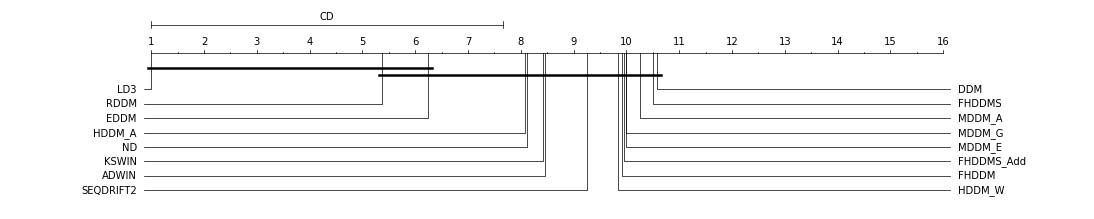

cd= 6.659026753589229


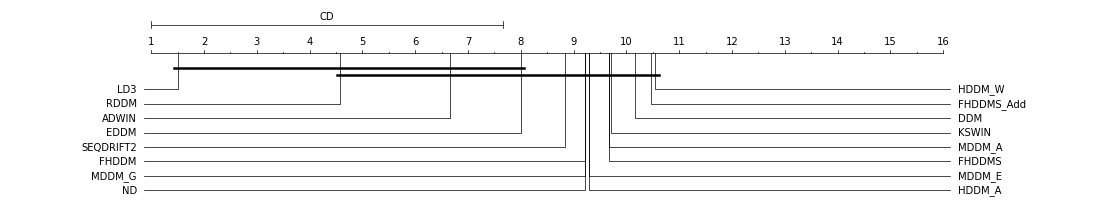

cd= 6.659026753589229


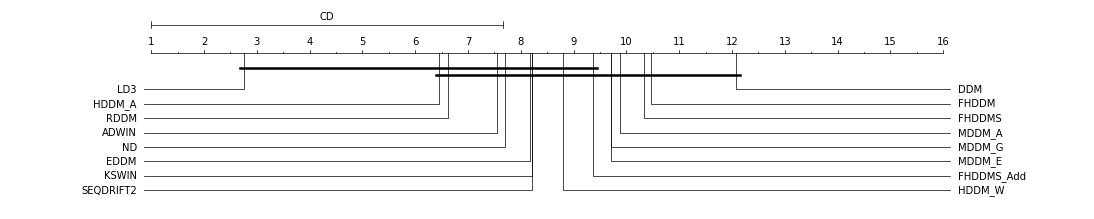

cd= 6.659026753589229


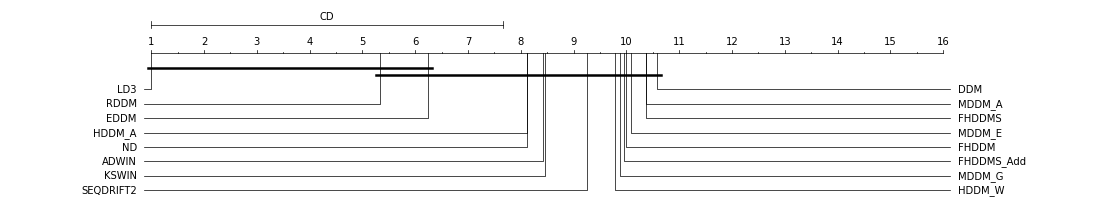

cd= 6.659026753589229


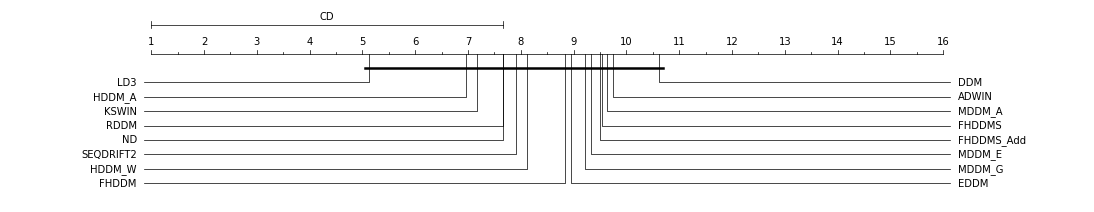

In [5]:
for i, result in enumerate(results):
    av_ranks = np.zeros((16,))
    for j in range(len(result)):
        if i == 1:
            vals = result[j]
        else:
            vals = result[j] * -1
        ranks = scipy.stats.rankdata(vals, method='average')
        av_ranks += ranks
    av_ranks *= 1/len(result)
    cd = Orange.evaluation.compute_CD(av_ranks, 12)
    print('cd=',cd)
    Orange.evaluation.graph_ranks(av_ranks, names, cd=cd, width=15, textspace=2, cd_method=0)
    plt.savefig('./Results/{}.png'.format(plot_names[i]), dpi=600)
    plt.show()
    plt.close()
    